In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

C:\Users\Asus\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
con = sqlite3.connect('final.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews limit 100000 """, con) 
final['label'] = np.where(final['Score']=='positive', 1, 0)

In [3]:
final.groupby('Score').count()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,label
Score,,,,,,,,,,,,
negative,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803
positive,85197,85197,85197,85197,85197,85197,85197,85197,85197,85197,85197,85197


In [4]:
# splitting into train & test data
X_train_f, X_test_f, Y_train, Y_test = train_test_split(final['CleanedText'], final['label'], train_size= 0.8)

# Bag of Words

In [5]:
#converting text to BOWs
count_vect = CountVectorizer(ngram_range=(1,2)) 
X_train_bow = count_vect.fit_transform(X_train_f.values)
X_test_bow = count_vect.transform(X_test_f)
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test = StandardScaler(with_mean=False).fit_transform(X_test_bow)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [6]:
#using GridSearchCV using 5 cross fold to find best value of C taking scoring as AUC value 
parameter = [{'C': [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
model = GridSearchCV(LogisticRegression( class_weight= 'balanced', penalty='l1'), parameter, scoring = 'roc_auc', cv=5)
model.fit(X_train, Y_train)
print(model.best_estimator_)
print(model.score(X_test, Y_test))

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9406907982173973


In [6]:
# splitting train data into training_new & validation data
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, train_size= 0.8)

In [8]:
# calculating AUC for training_new and validation dataset under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l1')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [9]:
auc_score_val

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.897854408325522,
 0.9317204618413368,
 0.9315561059331249,
 0.9292091566615575,
 0.9257078417525502,
 0.8715005373363895,
 0.791953790428806,
 0.7565310481399814]

In [10]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

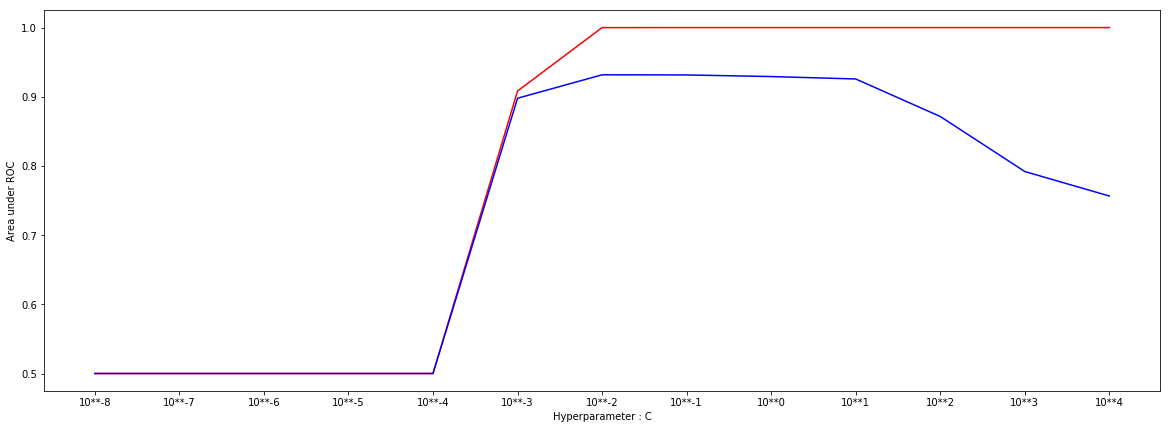

In [11]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [7]:
# Maximum AUC_ROC curve value is at C=1
clf = LogisticRegression(C= 1, class_weight= 'balanced', penalty='l1')
clf.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.937629203888408


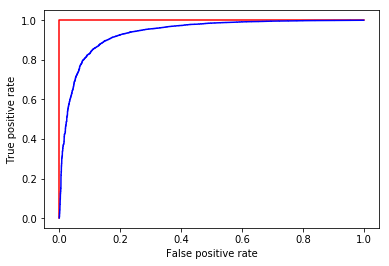

In [6]:
#plotting ROC curve for train and test data
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams["figure.figsize"] = [10,6]

plt.show()

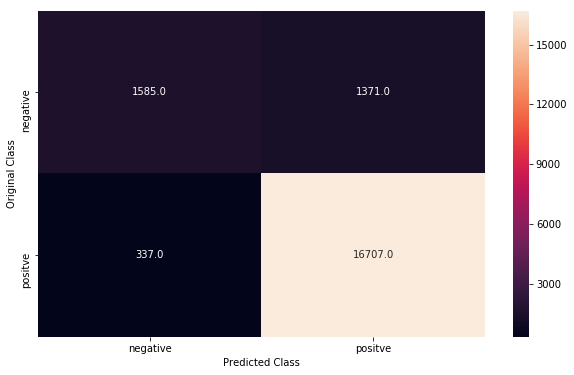

In [14]:
#plotting confusion matrix
import seaborn as sns
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positve"], yticklabels=["negative","positve"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [15]:
w = clf.coef_
print("The number of nonzero weights:",np.count_nonzero(w))
print("% nonzero weights:",(np.count_nonzero(w)/w.shape[1])*100)

The number of nonzero weights: 51485
% nonzero weights: 4.910202941067074


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [16]:
# calculating training_new and validation dataset AUC under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l2')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [17]:
auc_score_val

[0.9199132309469703,
 0.9326530673986411,
 0.9110068015685802,
 0.8730406485130977,
 0.8585225021266865,
 0.8519053245757525,
 0.848029531953641,
 0.8454940086652979,
 0.8464548609649039,
 0.8417397079058403,
 0.8405788131033767,
 0.8402769742805848,
 0.8402720040887699]

In [18]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

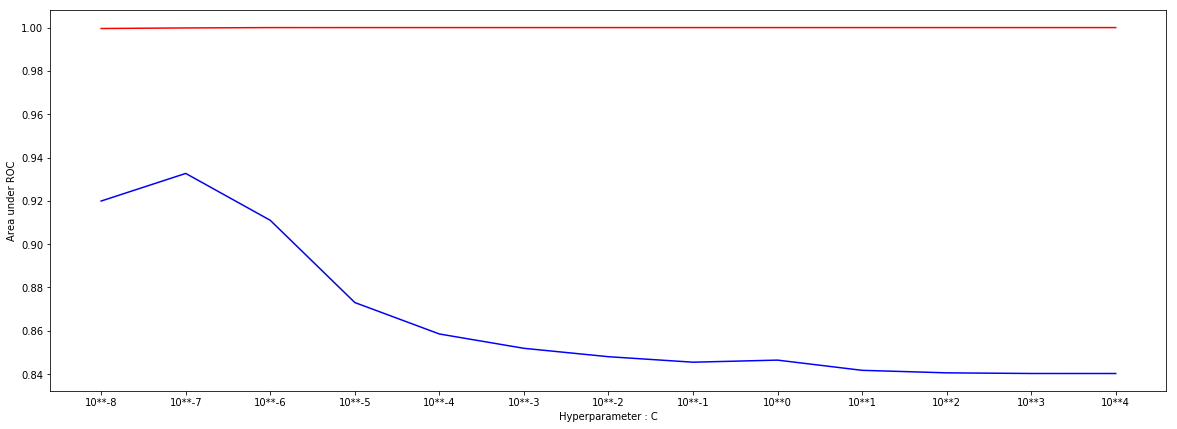

In [19]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [8]:
# Maximum AUC_ROC curve value is at C= 10**-7
clf = LogisticRegression(C= 10**-7, class_weight= 'balanced', penalty='l2')
clf.fit(X_train, Y_train)

LogisticRegression(C=1e-07, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.939977020620014


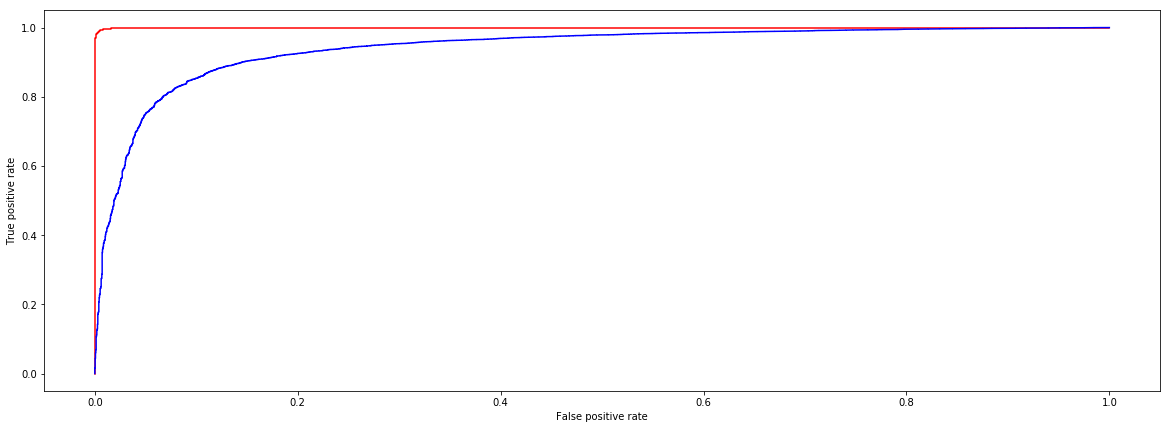

In [8]:
#plotting ROC curve for train and test data
plt.figure(figsize=(20,7))
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.show()

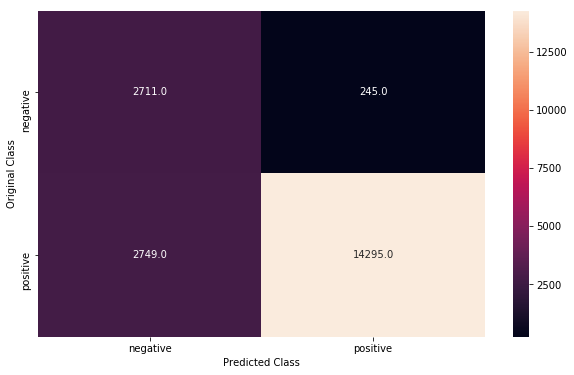

In [22]:
#plotting confusion matrix
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [23]:
X_train_noise = X_train
noise = np.random.normal(loc = 0.0 , scale = 0.01)
X_train_noise.data = X_train_noise.data + noise

In [24]:
clf_noise = LogisticRegression(C= 10**-7, class_weight= 'balanced', penalty='l2')
clf_noise.fit(X_train_noise, Y_train)

LogisticRegression(C=1e-07, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [25]:
w = clf.coef_
w_noise = clf_noise.coef_

In [26]:
w = w + 10**-6
w_noise = w_noise + 10**-6

In [27]:
w_change = abs((w_noise - w)/w)*100

In [28]:
percentile_values = [np.percentile(w_change,0), np.percentile(w_change,10),
                    np.percentile(w_change,20), np.percentile(w_change,30),
                    np.percentile(w_change,40), np.percentile(w_change,50),
                    np.percentile(w_change,60), np.percentile(w_change,70),
                    np.percentile(w_change,80), np.percentile(w_change,90), np.percentile(w_change,100)]

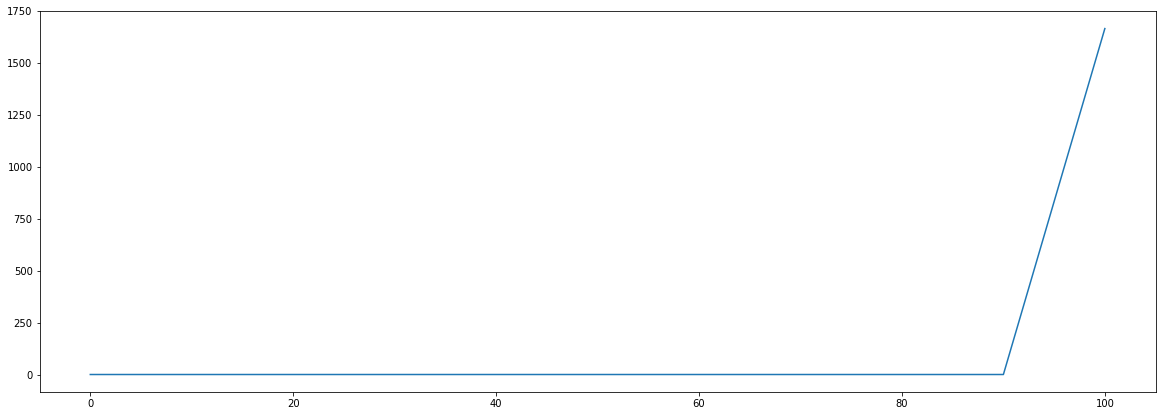

In [29]:
plt.figure(figsize=(20,7))
x_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.plot(x_values, percentile_values)

In [30]:
percentile_values = [np.percentile(w_change,90), np.percentile(w_change,91),
                    np.percentile(w_change,92), np.percentile(w_change,93),
                    np.percentile(w_change,94), np.percentile(w_change,95),
                    np.percentile(w_change,96), np.percentile(w_change,97),
                    np.percentile(w_change,98), np.percentile(w_change,99), np.percentile(w_change,100)]

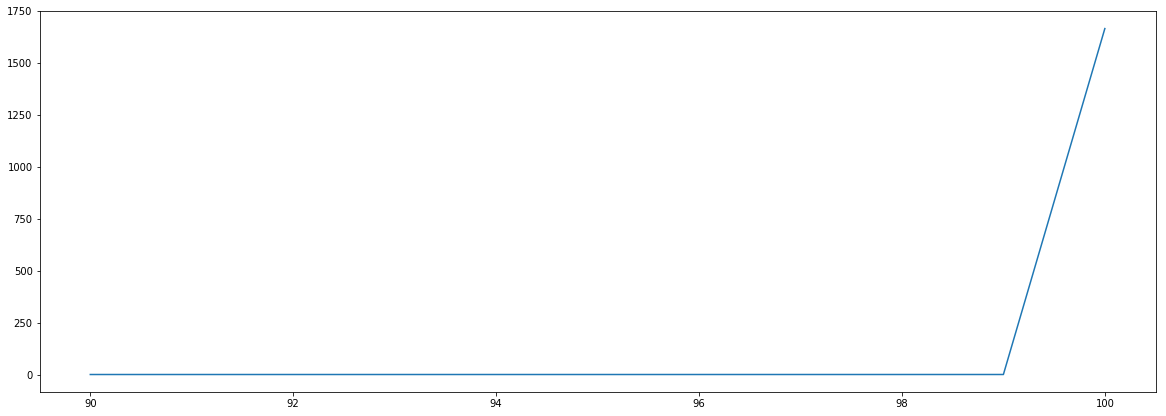

In [31]:
plt.figure(figsize=(20,7))
x_values = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
plt.plot(x_values, percentile_values)

In [32]:
percentile_values = [np.percentile(w_change,99), np.percentile(w_change,99.1),
                    np.percentile(w_change,99.2), np.percentile(w_change,99.3),
                    np.percentile(w_change,99.4), np.percentile(w_change,99.5),
                    np.percentile(w_change,99.6), np.percentile(w_change,99.7),
                    np.percentile(w_change,99.8), np.percentile(w_change,99.9), np.percentile(w_change,100)]

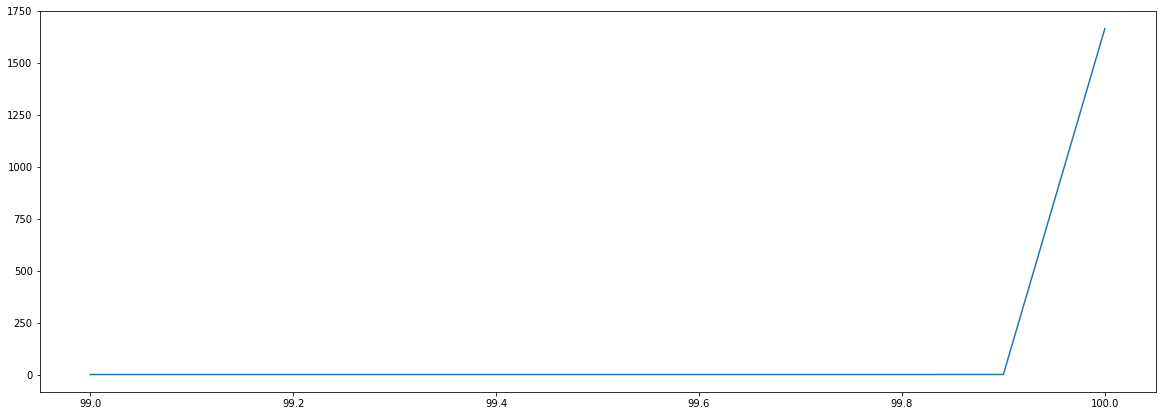

In [33]:
plt.figure(figsize=(20,7))
x_values = [99, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]
plt.plot(x_values, percentile_values)

In [34]:
percentile_values = [np.percentile(w_change,99.90), np.percentile(w_change,99.91),
                    np.percentile(w_change,99.92), np.percentile(w_change,99.93),
                    np.percentile(w_change,99.94), np.percentile(w_change,99.95),
                    np.percentile(w_change,99.96), np.percentile(w_change,99.97),
                    np.percentile(w_change,99.98), np.percentile(w_change,99.99), np.percentile(w_change,100)]

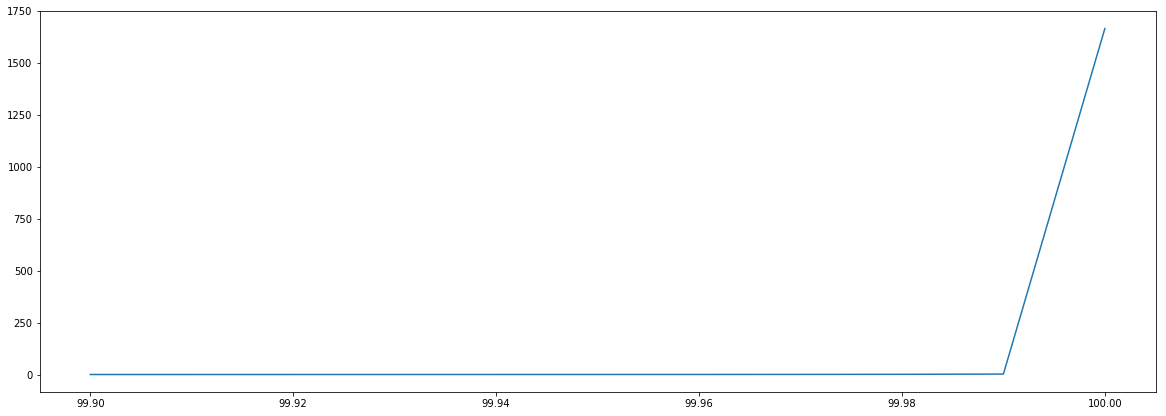

In [35]:
plt.figure(figsize=(20,7))
x_values = [99.90, 99.91, 99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.98, 99.99, 100]
plt.plot(x_values, percentile_values)

In [36]:
percentile_values = [np.percentile(w_change,99.9990), np.percentile(w_change,99.9991),
                    np.percentile(w_change,99.9992), np.percentile(w_change,99.9993),
                    np.percentile(w_change,99.9994), np.percentile(w_change,99.9995),
                    np.percentile(w_change,99.9996), np.percentile(w_change,99.9997),
                    np.percentile(w_change,99.9998), np.percentile(w_change,99.9999), np.percentile(w_change,100)]

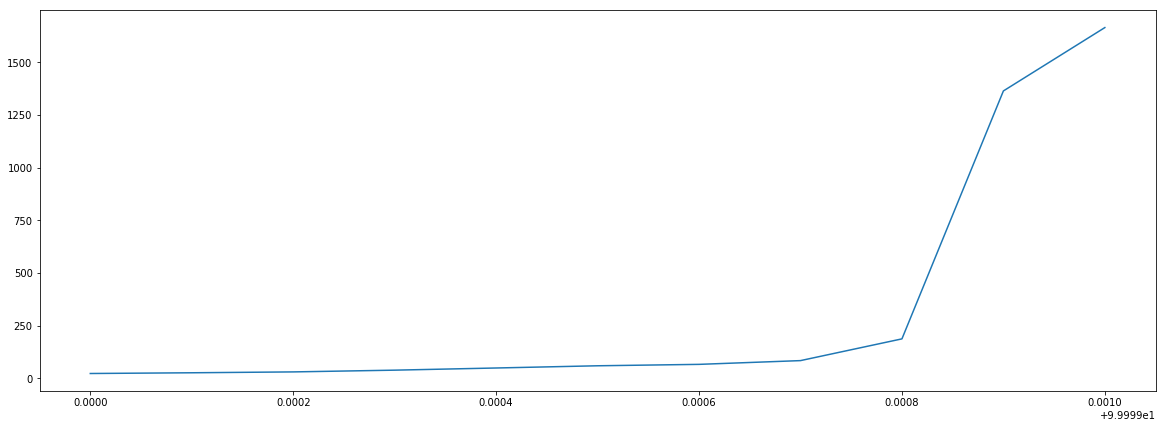

In [37]:
plt.figure(figsize=(20,7))
x_values = [99.9990, 99.9991, 99.9992, 99.9993, 99.9994, 99.9995, 99.9996, 99.9997, 99.9998, 99.9999, 100]
plt.plot(x_values, percentile_values)

In [38]:
percentile_values

[22.30266371075464,
 25.76801313459985,
 29.882310370071036,
 38.1828491539425,
 48.476178697911585,
 58.9986072193628,
 65.69963469427867,
 83.52598106597829,
 186.7586991991217,
 1364.0399866320975,
 1664.9276198213176]

In [9]:
bow_feature_names = count_vect.get_feature_names()

In [40]:
# position where % change is greater than threshold x
iz, jz = np.where(w_change > 186.758)

# feature names whose % change is more than a threshold x(here it is 68.9)
for index in jz:
    print(bow_feature_names[index])

day occasion
mole kill
much sum


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [11]:
w = clf.coef_
w_new = (w.T).reshape(w.shape[1],) 
ranking_index = np.argsort(w_new)
top_10 = ranking_index[-10:] 
for index in top_10:
    print(bow_feature_names[index])

excel
find
easi
high recommend
favorit
perfect
delici
best
love
great


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [12]:
bottom_10 =  ranking_index[0:10]
for index in bottom_10:
    print(bow_feature_names[index])

disappoint
wast money
wast
money
return
worst
horribl
threw
aw
terribl


# TFIDF

In [13]:
#converting text to TFIDF
count_vect = TfidfVectorizer(ngram_range=(1,2)) 
X_train_bow = count_vect.fit_transform(X_train_f.values)
X_test_bow = count_vect.transform(X_test_f)
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test = StandardScaler(with_mean=False).fit_transform(X_test_bow)

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [5]:
# splitting train data into training_new & validation data
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, train_size= 0.8)

In [6]:
# calculating AUC for training_new and validation dataset under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l1')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [7]:
auc_score_val

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.9110810808654773,
 0.9424758944789641,
 0.9420483091633287,
 0.9423039828455324,
 0.9420389597232183,
 0.8736348501177854,
 0.7847004868569369,
 0.7613149524829863]

In [8]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

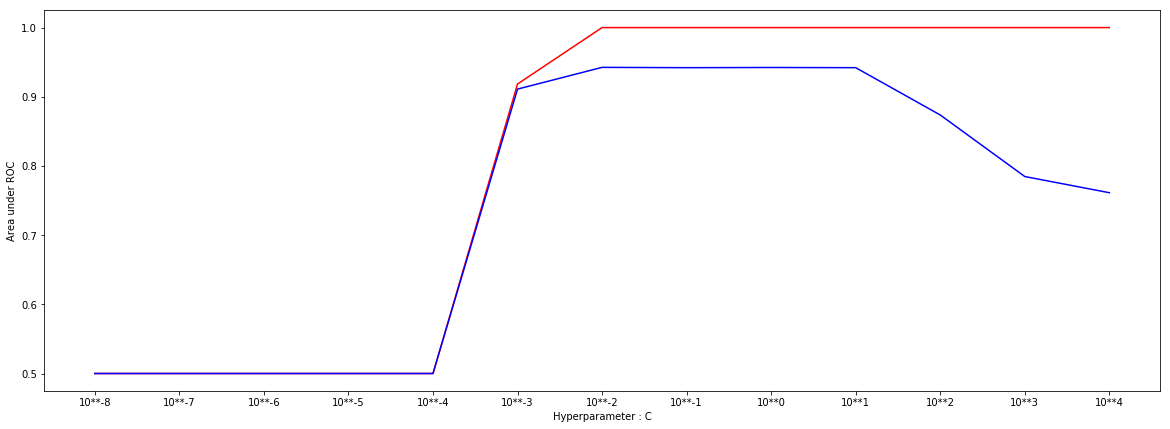

In [9]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [10]:
# Maximum AUC_ROC curve value is at C=0.1
clf = LogisticRegression(C= 0.1, class_weight= 'balanced', penalty='l1')
clf.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.9453958422875454


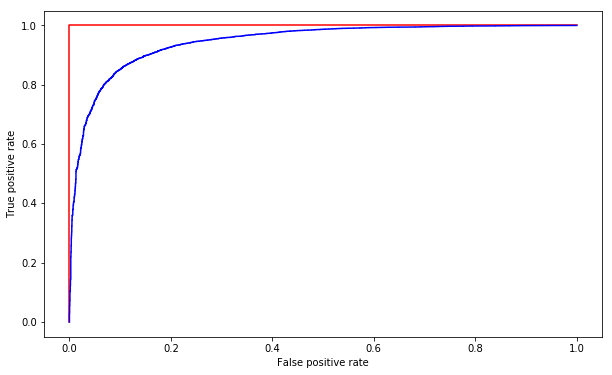

In [11]:
#plotting ROC curve for train and test data
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams["figure.figsize"] = [10,6]

plt.show()

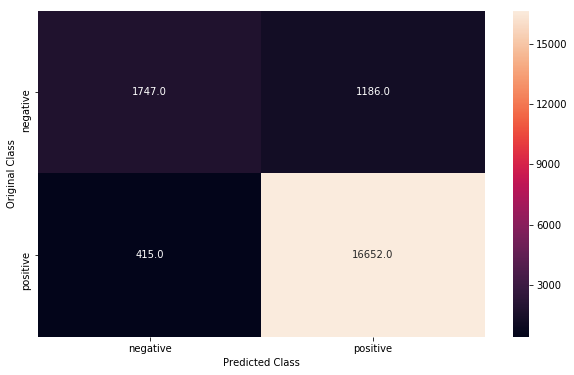

In [13]:
#plotting confusion matrix
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [14]:
# calculating training_new and validation dataset AUC under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l2')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [15]:
auc_score_val

[0.937616195910657,
 0.9430173323622253,
 0.9379779841426477,
 0.91840076710082,
 0.911508889546576,
 0.9089134466806696,
 0.9075696481435537,
 0.9069609772558118,
 0.9058038484273875,
 0.9041507206328263,
 0.9038598987994905,
 0.9038634726469047,
 0.9038374984344474]

In [16]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

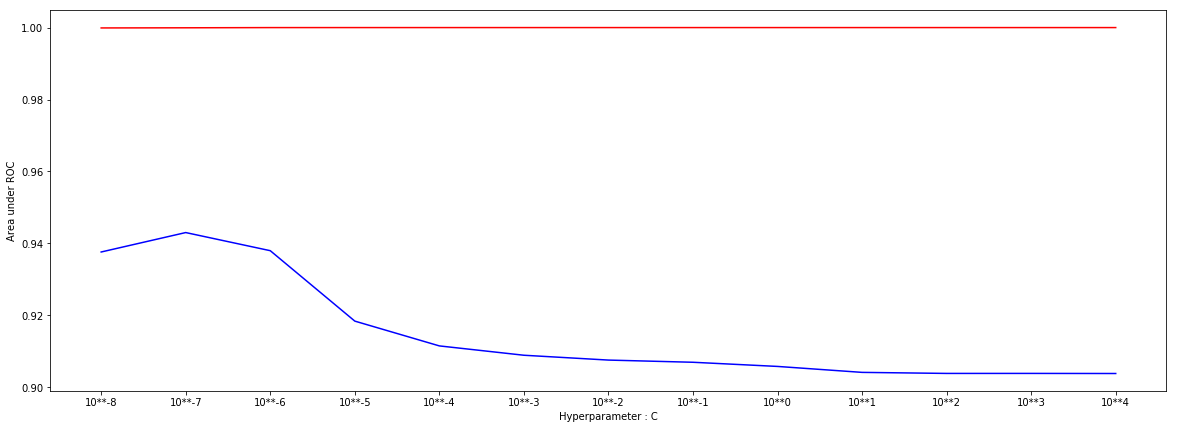

In [17]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [14]:
# Maximum AUC_ROC curve value is at C= 10**-7
clf = LogisticRegression(C= 10**-7, class_weight= 'balanced', penalty='l2')
clf.fit(X_train, Y_train)

LogisticRegression(C=1e-07, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.9441036965551561


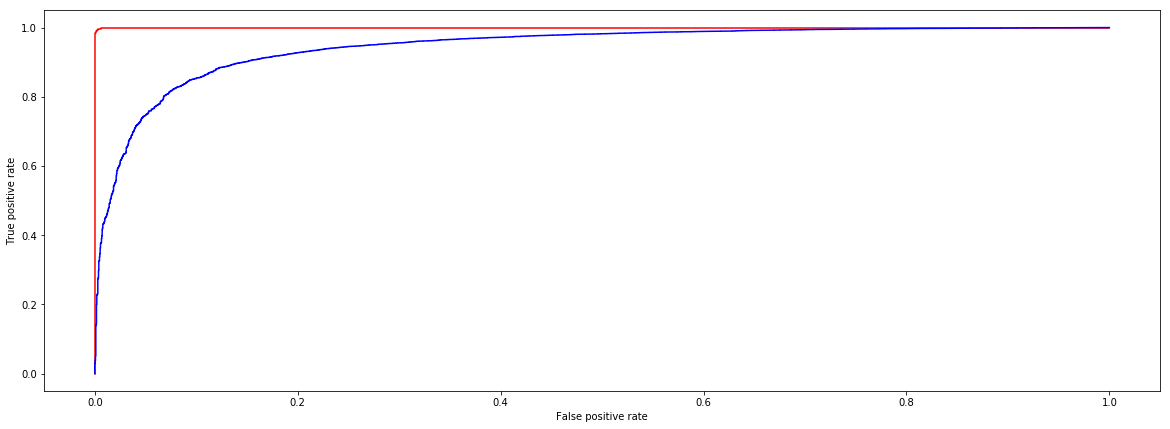

In [13]:
#plotting ROC curve for train and test data
plt.figure(figsize=(20,7))
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.show()

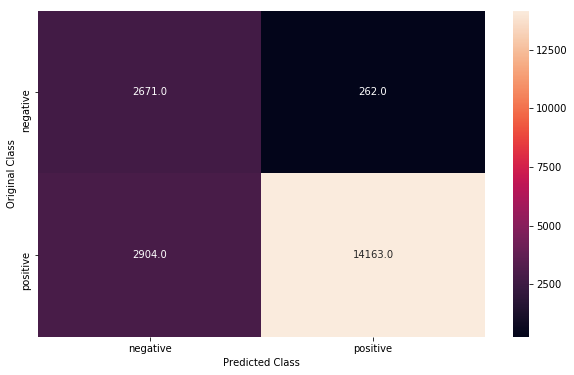

In [20]:
#plotting confusion matrix
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [15]:
bow_feature_names = count_vect.get_feature_names()
w = clf.coef_
w_new = (w.T).reshape(w.shape[1],) 
ranking_index = np.argsort(w_new)
top_10 = ranking_index[-10:]
for index in top_10:
    print(bow_feature_names[index])

easi
good
make
favorit
find
perfect
delici
best
love
great


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [16]:
bottom_10 = ranking_index[0:10]
for index in bottom_10:
    print(bow_feature_names[index])

disappoint
wast
wast money
return
worst
money
horribl
terribl
threw
aw


# Avg2Vec

In [7]:
# taking only 1k data since large data is taking too long
con = sqlite3.connect('final.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews limit 1000 """, con) 
final['label'] = np.where(final['Score']=='positive', 1, 0)

In [8]:
# splitting into train & test data
X_train_f, X_test_f, Y_train, Y_test = train_test_split(final['CleanedText'], final['label'], train_size= 0.8)

In [9]:
list_of_sent=[]
for sent in X_train_f.values:
    list_of_sent.append(sent.split())

In [10]:
w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
w2v_words = list(w2v_model.wv.vocab)

In [12]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [11:14<00:00,  1.38s/it]


In [13]:
X_train = pd.DataFrame(np.row_stack(sent_vectors))

In [14]:
list_of_sent=[]
for sent in X_test_f.values:
    list_of_sent.append(sent.split())

In [15]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:48<00:00,  2.11it/s]


In [16]:
X_test = pd.DataFrame(np.row_stack(sent_vectors))

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [17]:
# splitting train data into training_new & validation data
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, train_size= 0.8)

In [18]:
# calculating AUC for training_new and validation dataset under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l1')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [19]:
auc_score_val

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7939285714285714,
 0.8075000000000001,
 0.7985714285714286,
 0.7976785714285715,
 0.7903571428571429]

In [20]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

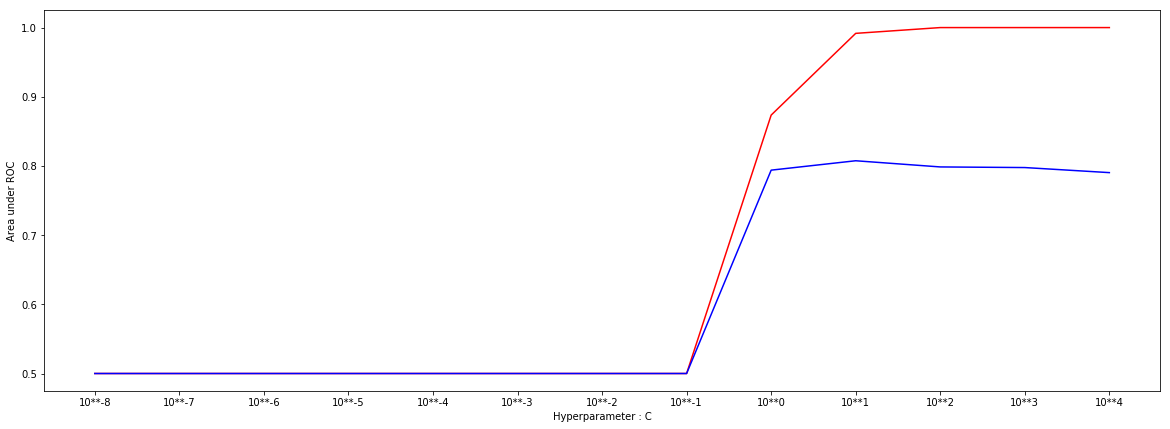

In [21]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [22]:
# Maximum AUC_ROC curve value is at C=10
clf = LogisticRegression(C= 10, class_weight= 'balanced', penalty='l1')
clf.fit(X_train, Y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.77373830342077


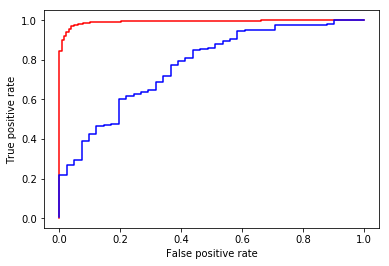

In [23]:
#plotting ROC curve for train and test data
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams["figure.figsize"] = [10,6]

plt.show()

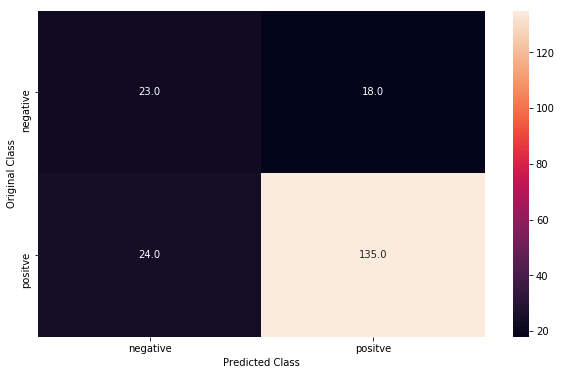

In [24]:
#plotting confusion matrix
import seaborn as sns
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positve"], yticklabels=["negative","positve"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [25]:
# calculating training_new and validation dataset AUC under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l2')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [26]:
auc_score_val

[0.775,
 0.775,
 0.775,
 0.775,
 0.775,
 0.7753571428571429,
 0.7782142857142857,
 0.7928571428571428,
 0.8264285714285715,
 0.8296428571428571,
 0.8189285714285715,
 0.8028571428571429,
 0.7887500000000001]

In [27]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

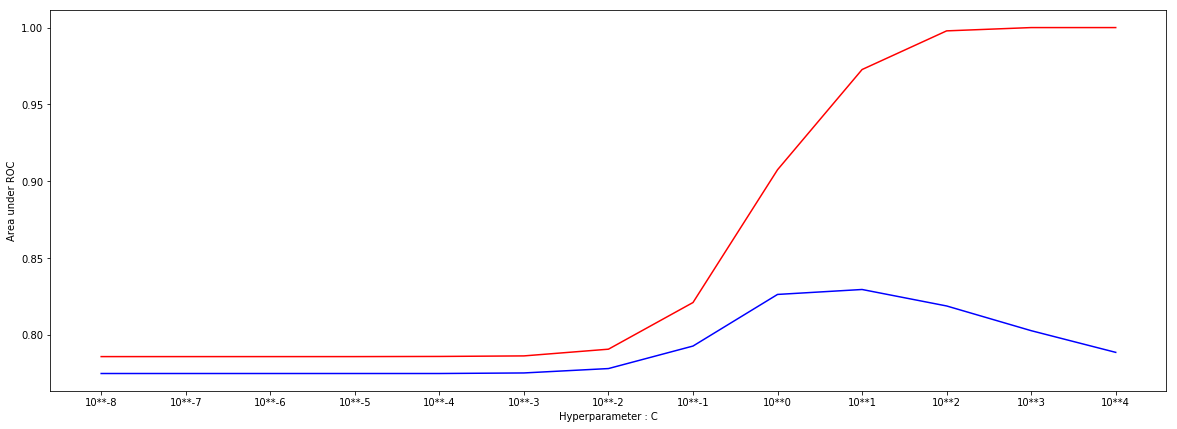

In [28]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [29]:
# Maximum AUC_ROC curve value is at C= 10
clf = LogisticRegression(C= 1, class_weight= 'balanced', penalty='l2')
clf.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.839852738150023


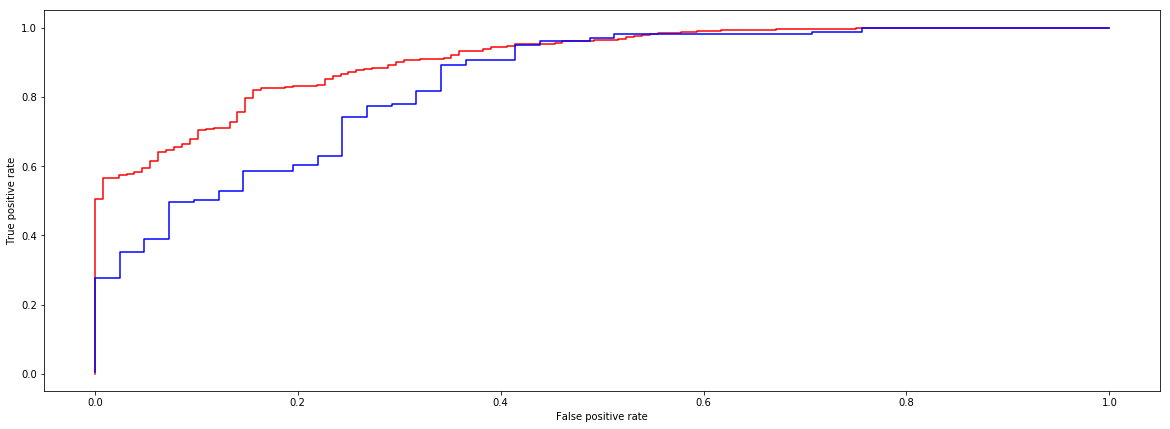

In [30]:
#plotting ROC curve for train and test data
plt.figure(figsize=(20,7))
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.show()

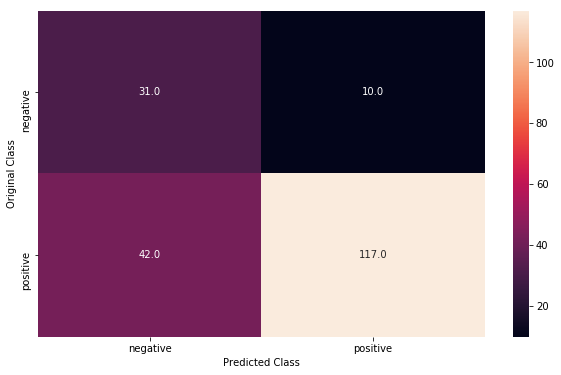

In [31]:
#plotting confusion matrix
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# TFIDF W2V

In [43]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_f.values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
list_of_sent=[]
for sent in X_train_f.values:
    list_of_sent.append(sent.split())

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [11:06<00:00,  1.28s/it]


In [35]:
X_train = pd.DataFrame(np.row_stack(tfidf_sent_vectors))

In [44]:
tf_idf_matrix = model.transform(X_test_f.values)

In [45]:
list_of_sent=[]
for sent in X_test_f.values:
    list_of_sent.append(sent.split())

In [58]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            dictionary_value = dictionary[word] if word in dictionary.keys() else 0 
            # if the word is not present in train data then idf value is zero
            tf_idf = dictionary_value*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:45<00:00,  3.28it/s]


In [59]:
X_test = pd.DataFrame(np.row_stack(tfidf_sent_vectors))

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [60]:
# splitting train data into training_new & validation data
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, train_size= 0.8)

In [61]:
# calculating AUC for training_new and validation dataset under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l1')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [62]:
auc_score_val

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7850172215843857,
 0.7545924225028702,
 0.731630309988519,
 0.7301951779563721,
 0.7036452353616531]

In [63]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

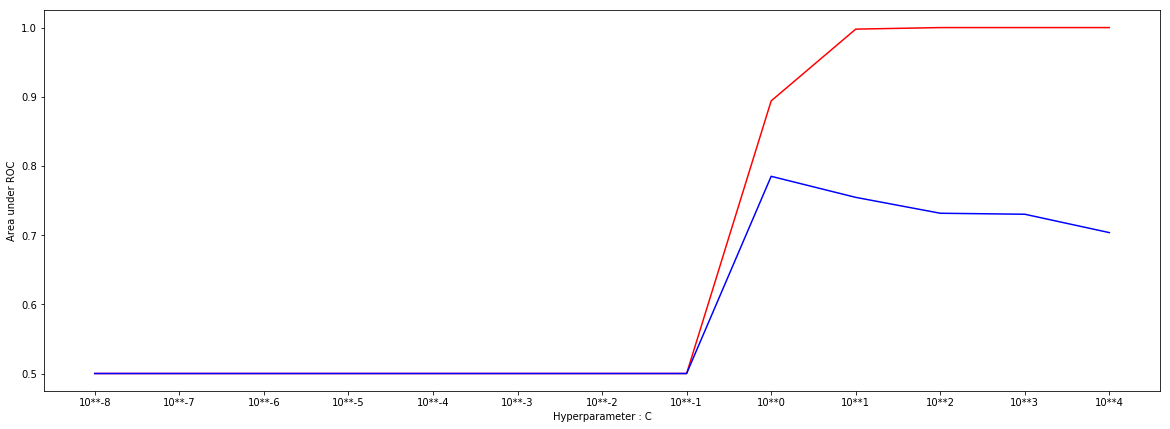

In [64]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [66]:
# Maximum AUC_ROC curve value is at C=1
clf = LogisticRegression(C= 1, class_weight= 'balanced', penalty='l1')
clf.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.8180702561742599


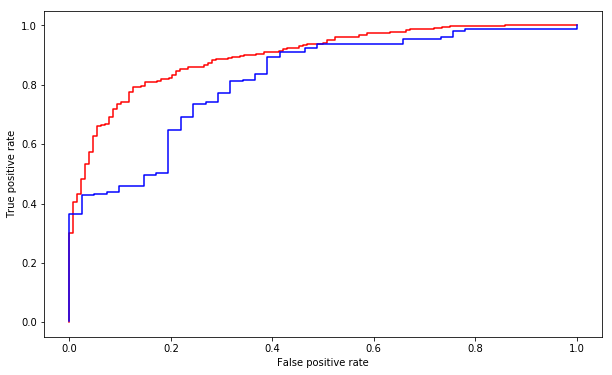

In [67]:
#plotting ROC curve for train and test data
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams["figure.figsize"] = [10,6]

plt.show()

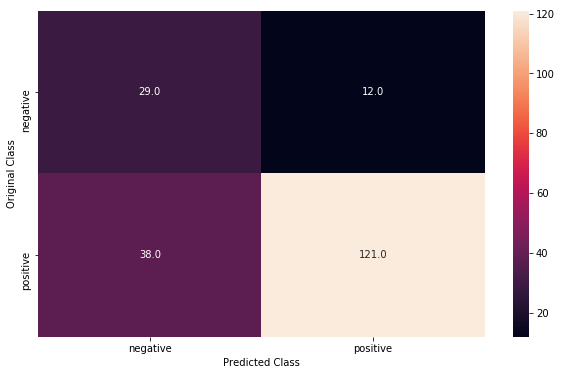

In [68]:
#plotting confusion matrix
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [69]:
# calculating training_new and validation dataset AUC under different values of C (hyperparameter)
param = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score_train = []
auc_score_val = []
for value_p in param:
    clf = LogisticRegression(C = value_p, class_weight= 'balanced', penalty='l2')
    clf.fit(x_train, y_train)
    #https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
    false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
    auc_score_train.append(auc(false_positive_rate_tr, true_positive_rate_tr))
    false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    auc_score_val.append(auc(false_positive_rate_val, true_positive_rate_val))

In [70]:
auc_score_val

[0.7204362801377726,
 0.7204362801377726,
 0.7204362801377726,
 0.7204362801377726,
 0.7204362801377726,
 0.720723306544202,
 0.7235935706084958,
 0.7477037887485648,
 0.7964982778415615,
 0.7907577497129736,
 0.7508610792192882,
 0.7342135476463834,
 0.731630309988519]

In [71]:
param_x = ['10**-8', '10**-7', '10**-6', '10**-5', '10**-4', '10**-3', '10**-2', '10**-1', '10**0', '10**1', '10**2', '10**3',
          '10**4']

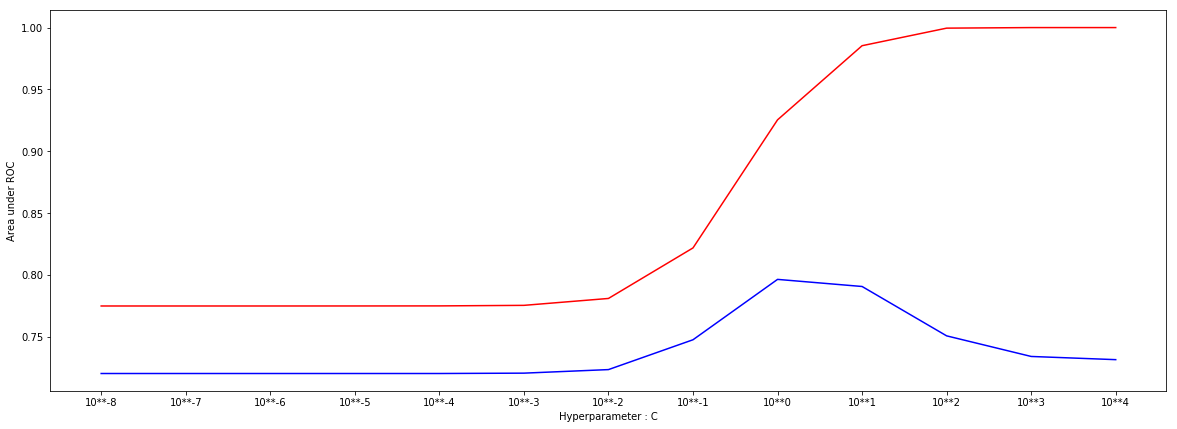

In [72]:
#plotting AUC values for different values of C
plt.figure(figsize=(20,7))
plt.plot(param_x, auc_score_train, color = 'r', label="Train AUC")
plt.plot(param_x, auc_score_val, color = 'b', label="Validation AUC")
plt.xlabel('Hyperparameter : C')
plt.ylabel('Area under ROC')
plt.show()

In [73]:
# Maximum AUC_ROC curve value is at C= 1
clf = LogisticRegression(C= 1, class_weight= 'balanced', penalty='l2')
clf.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.8292682926829268


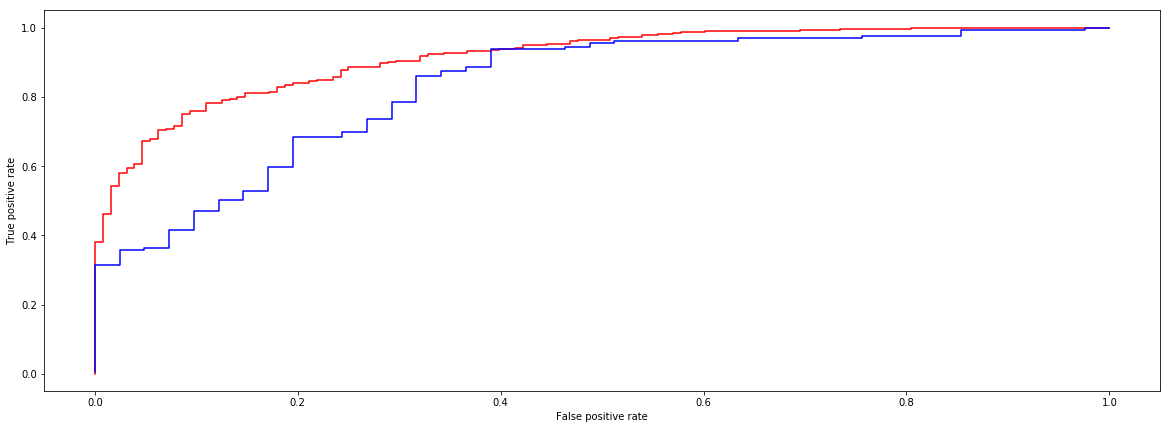

In [74]:
#plotting ROC curve for train and test data
plt.figure(figsize=(20,7))
false_positive_rate_train, true_positive_rate_train, thresholds_test = roc_curve(Y_train, clf.predict_proba(X_train)[:,1])
plt.plot(false_positive_rate_train,true_positive_rate_train,  color = 'r', label="Train ROC")

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
print(auc(false_positive_rate_test, true_positive_rate_test))
plt.plot(false_positive_rate_test,true_positive_rate_test, color = 'b', label="Test ROC")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.show()

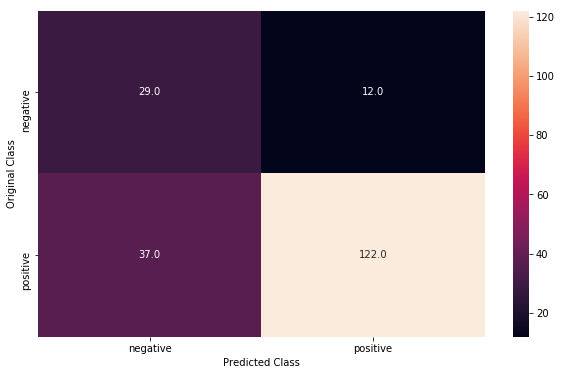

In [75]:
#plotting confusion matrix
C = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(C,annot=True, fmt=".1f", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# [6] Conclusions

In [76]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Regularization", "Hyperparameter (C)", "AUC"]

x.add_row(["BOW", "LogisticRegression", "L1", 1, 0.937])
x.add_row(["BOW", "LogisticRegression", "L2", 10**-7, 0.939])
x.add_row(["TFIDF", "LogisticRegression", "L1", 0.1, 0.945])
x.add_row(["TFIDF", "LogisticRegression", "L2", 10**-7, 0.944])
x.add_row(["Avg W2V", "LogisticRegression", "L1", 10, 0.773])
x.add_row(["Avg W2V", "LogisticRegression", "L2", 10, 0.839])
x.add_row(["TFIDF W2V", "LogisticRegression", "L1", 1, 0.818])
x.add_row(["TFIDF W2V", "LogisticRegression", "L2", 1, 0.829])

print(x)

+------------+--------------------+----------------+--------------------+-------+
| Vectorizer |       Model        | Regularization | Hyperparameter (C) |  AUC  |
+------------+--------------------+----------------+--------------------+-------+
|    BOW     | LogisticRegression |       L1       |         1          | 0.937 |
|    BOW     | LogisticRegression |       L2       |       1e-07        | 0.939 |
|   TFIDF    | LogisticRegression |       L1       |        0.1         | 0.945 |
|   TFIDF    | LogisticRegression |       L2       |       1e-07        | 0.944 |
|  Avg W2V   | LogisticRegression |       L1       |         10         | 0.773 |
|  Avg W2V   | LogisticRegression |       L2       |         10         | 0.839 |
| TFIDF W2V  | LogisticRegression |       L1       |         1          | 0.818 |
| TFIDF W2V  | LogisticRegression |       L2       |         1          | 0.829 |
+------------+--------------------+----------------+--------------------+-------+
